## To level 1 and initialization

In [ ]:
import os
import re
import pandas as pd
import spacy
from spacy.lang.en import English
import language_tool_python
from datetime import datetime
import json

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize LanguageTool for spell checking
language_tool = language_tool_python.LanguageTool('en-US')

from google.generativeai import GenerativeModel

# Initialize the GenerativeModel (ensure you've set up the API key as per the previous instructions)
model = GenerativeModel("gemini-1.5-flash")

def generate_job_description(resume_text):
    prompt = f"""Based on the following resume, generate a concise job description that this person would be best suited for. Focus on the key skills, experience, and qualifications mentioned:

    {resume_text}

    Job Description:"""

    response = model.generate_content(prompt)
    return response.text

def load_and_clean_data(directory):
    """Load data from text files in the specified directory and perform initial cleaning."""
    data = []
    for filename in os.listdir(directory):
        if filename.startswith("Resume_of_ID_") and filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            id_number = int(filename.split('_')[3].split('.')[0])
            clean_text = ' '.join(text.split())  # Remove extra whitespace
            data.append({'ID': id_number, 'Text': clean_text})
    return pd.DataFrame(data)

def preprocess_text(text):
    """Preprocess text using spaCy for tokenization and lemmatization."""
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return tokens

def extract_years_of_experience(text):
    """Extract years of experience from the resume text."""
    years = re.findall(r'\b(19[7-9]\d|20[0-2]\d)\b', text)
    if len(years) >= 2:
        earliest_year = min(int(year) for year in years)
        latest_year = max(int(year) for year in years)
        current_year = datetime.now().year
        if latest_year > current_year:
            latest_year = current_year
        return latest_year - earliest_year
    return 0

def detect_education_level(text):
    """Detect the highest education level mentioned in the resume."""
    education_patterns = {
        'PhD': r'\bPh\.?D\.?\b|\bDoctor(ate)?\b',
        'Master': r'\bM\.?S\.?\b|\bM\.?A\.?\b|\bMaster\b',
        'Bachelor': r'\bB\.?S\.?\b|\bB\.?A\.?\b|\bBachelor\b',
        'Associate': r'\bA\.?S\.?\b|\bA\.?A\.?\b|\bAssociate\b'
    }

    for level, pattern in education_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            return level
    return 'Other'

def calculate_spell_check_ratio(text):
    """Calculate the ratio of potential spelling errors to total words."""
    matches = language_tool.check(text)
    total_words = len(text.split())
    return 1 - (len(matches) / total_words)

def identify_resume_sections(text):
    """Identify and score the presence of important resume sections."""
    important_sections = ['education', 'experience', 'skills', 'projects', 'achievements']
    optional_sections = ['summary', 'objective', 'interests', 'activities']
    unnecessary_sections = ['references']

    section_score = 0
    for section in important_sections:
        if re.search(r'\b' + section + r'\b', text, re.IGNORECASE):
            section_score += 1

    for section in optional_sections:
        if re.search(r'\b' + section + r'\b', text, re.IGNORECASE):
            section_score += 0.5

    for section in unnecessary_sections:
        if re.search(r'\b' + section + r'\b', text, re.IGNORECASE):
            section_score -= 0.5

    return min(section_score / len(important_sections), 1)

def quantify_brevity(text):
    """Quantify the brevity of the resume."""
    word_count = len(text.split())
    if word_count < 200:
        return 0.5  # Too short
    elif word_count > 1000:
        return 0.5  # Too long
    else:
        return 1 - (abs(600 - word_count) / 400)  # Optimal around 600 words

def process_resume(row):
    """Process a single resume and return a dictionary of features."""
    text = row['Text']
    tokens = preprocess_text(text)

    years_of_experience = extract_years_of_experience(text)
    education_level = detect_education_level(text)
    spell_check_ratio = calculate_spell_check_ratio(text)
    section_score = identify_resume_sections(text)
    brevity_score = quantify_brevity(text)

    # Generate job description based on the resume
    job_description = generate_job_description(text)

    return {
        'ID': row['ID'],
        'Preprocessed_Tokens': tokens,
        'Years_of_Experience': years_of_experience,
        'Education_Level': education_level,
        'Spell_Check_Ratio': spell_check_ratio,
        'Section_Score': section_score,
        'Brevity_Score': brevity_score,
        'Generated_Job_Description': job_description
    }

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from textblob import TextBlob

def calculate_word_sentence_counts(text):
    """Calculate word count and sentence count."""
    sentences = re.split(r'[.!?]+', text)
    word_count = len(text.split())
    sentence_count = len([s for s in sentences if s.strip()])
    return word_count, sentence_count

def extract_skills(text, skill_list):
    """Extract skills from text based on a predefined skill list."""
    found_skills = [skill for skill in skill_list if re.search(r'\b' + re.escape(skill) + r'\b', text, re.IGNORECASE)]
    return found_skills

def calculate_skill_match_score(resume_skills, job_skills):
    """Calculate the skill match score."""
    if not job_skills:
        return 0
    matched_skills = set(resume_skills) & set(job_skills)
    return len(matched_skills) / len(job_skills)

def analyze_sentiment(text):
    """Analyze the sentiment of achievement statements in the resume."""
    blob = TextBlob(text)
    return blob.sentiment.polarity

def quantify_achievement_impact(text):
    """Quantify the impact of achievements."""
    impact_score = 0
    achievements = re.findall(r'\b(increased|decreased|improved|reduced|saved|generated).*?(\d+(?:\.\d+)?%?)', text, re.IGNORECASE)
    for _, value in achievements:
        if '%' in value:
            impact_score += float(value.strip('%')) / 100
        else:
            impact_score += float(value) / 1000  # Assume larger numbers for non-percentage values
    return min(impact_score, 1)

def calculate_technical_score(row):
    """Calculate the technical CV score."""
    skill_count = len(row['Extracted_Skills'])
    experience_score = min(row['Years_of_Experience'] / 10, 1)  # Cap at 10 years
    education_score = {'PhD': 1, 'Master': 0.8, 'Bachelor': 0.6, 'Associate': 0.4, 'Other': 0.2}.get(row['Education_Level'], 0.2)

    return (skill_count / 10 * 0.4 + experience_score * 0.3 + education_score * 0.3)

def calculate_managerial_score(row):
    """Calculate the managerial CV score."""
    soft_skills_score = analyze_sentiment(row['Text'])
    achievement_impact = quantify_achievement_impact(row['Text'])
    leadership_score = min(row['Years_of_Experience'] / 15, 1)  # Assume leadership potential increases with experience

    return (soft_skills_score * 0.3 + achievement_impact * 0.4 + leadership_score * 0.3)

def calculate_overall_score(row):
    """Calculate the overall CV score."""
    technical_score = row['Technical_Score']
    managerial_score = row['Managerial_Score']
    resume_quality_score = (row['Spell_Check_Ratio'] + row['Section_Score'] + row['Brevity_Score']) / 3
    return (technical_score * 0.4 + managerial_score * 0.3 + resume_quality_score * 0.3)

def process_resume_section2(row, job_skills):
    """Process a single resume for Section 2 analysis."""
    word_count, sentence_count = calculate_word_sentence_counts(row['Text'])

    # Combine general and technical skills
    all_skills = job_skills['general_skills'] + job_skills['technical_skills']

    # Extract skills based on the generated job description
    job_specific_skills = extract_skills(row['Generated_Job_Description'], all_skills)
    resume_skills = extract_skills(row['Text'], all_skills)

    technical_score = calculate_technical_score(row, job_specific_skills)
    managerial_score = calculate_managerial_score(row)
    resume_quality_score = (row['Spell_Check_Ratio'] + row['Section_Score'] + row['Brevity_Score']) / 3
    overall_score = calculate_overall_score(technical_score, managerial_score, resume_quality_score)

    return {
        'ID': row['ID'],
        'Word_Count': word_count,
        'Sentence_Count': sentence_count,
        'Resume_Skills': resume_skills,
        'Job_Specific_Skills': job_specific_skills,
        'Technical_Score': technical_score,
        'Managerial_Score': managerial_score,
        'Resume_Quality_Score': resume_quality_score,
        'Overall_Score': overall_score
    }

def normalize_scores(df):
    """Normalize scores to ensure fair comparison across all resumes."""
    score_columns = ['Technical_Score', 'Managerial_Score', 'Resume_Quality_Score', 'Overall_Score']
    for column in score_columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df

def process_resumes_section2(df, job_skills):
    """Process all resumes for Section 2 analysis."""
    results = []
    for _, row in df.iterrows():
        results.append(process_resume_section2(row, job_skills))

    results_df = pd.DataFrame(results)
    normalized_df = normalize_scores(results_df)
    return normalized_df

# This function will be called from the main function in Section 3
def run_section2(input_file, job_skills):
    """Run Section 2 processing on the input file."""
    df = pd.read_csv(input_file)
    processed_df = process_resumes_section2(df, job_skills)
    processed_df.to_csv('processed_resumes_section2.csv', index=False)
    print("Section 2 processing completed. Results saved to 'processed_resumes_section2.csv'")
    return processed_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from typing import List, Dict

def load_job_skills(file_path: str) -> List[str]:
    """Load job skills from a JSON file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def job_description_matching(resume_text: str, job_description: str) -> float:
    """Calculate similarity between resume and job description."""
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([resume_text, job_description])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def adjust_scores_with_job_match(df: pd.DataFrame, job_description: str) -> pd.DataFrame:
    """Adjust scores based on job description matching."""
    df['Job_Match_Score'] = df['Text'].apply(lambda x: job_description_matching(x, job_description))
    df['Adjusted_Overall_Score'] = (df['Overall_Score'] * 0.7 + df['Job_Match_Score'] * 0.3)
    return df

def rank_resumes(df: pd.DataFrame) -> pd.DataFrame:
    """Rank resumes based on adjusted overall score."""
    return df.sort_values('Adjusted_Overall_Score', ascending=False).reset_index(drop=True)

def generate_report(df: pd.DataFrame, top_n: int = 10) -> Dict:
    """Generate a report with top candidates and summary statistics."""
    top_candidates = df.head(top_n)[['ID', 'Adjusted_Overall_Score', 'Technical_Score', 'Managerial_Score', 'Job_Match_Score']]
    summary_stats = df[['Adjusted_Overall_Score', 'Technical_Score', 'Managerial_Score', 'Job_Match_Score']].describe()

    return {
        'top_candidates': top_candidates.to_dict(orient='records'),
        'summary_stats': summary_stats.to_dict()
    }

def match_resume_to_job_description(resume_text, job_description):
    """Match a resume to a specific job description and return adjusted scores."""
    # Reuse the existing job_description_matching function
    match_score = job_description_matching(resume_text, job_description)

    # Recalculate scores based on the new job description
    job_specific_skills = extract_skills(job_description, general_job_skills)
    resume_skills = extract_skills(resume_text, job_specific_skills)

    technical_score = calculate_technical_score({'Text': resume_text, 'Years_of_Experience': extract_years_of_experience(resume_text), 'Education_Level': detect_education_level(resume_text)}, job_specific_skills)
    managerial_score = calculate_managerial_score({'Text': resume_text})
    resume_quality_score = (calculate_spell_check_ratio(resume_text) + identify_resume_sections(resume_text) + quantify_brevity(resume_text)) / 3
    overall_score = calculate_overall_score(technical_score, managerial_score, resume_quality_score)

    adjusted_overall_score = overall_score * 0.7 + match_score * 0.3

    return {
        'Technical_Score': technical_score,
        'Managerial_Score': managerial_score,
        'Resume_Quality_Score': resume_quality_score,
        'Overall_Score': overall_score,
        'Job_Match_Score': match_score,
        'Adjusted_Overall_Score': adjusted_overall_score
    }

def create_default_job_skills_file(file_path):
    """Create a default job_skills.json file if it doesn't exist."""
    default_skills = {
        "general_skills": [
            "communication", "teamwork", "leadership", "problem-solving",
            "time management", "analytical skills", "creativity", "adaptability"
        ],
        "technical_skills": [
            "programming", "data analysis", "project management",
            "software development", "database management", "web development"
        ]
    }

    with open(file_path, 'w') as file:
        json.dump(default_skills, file, indent=2)

import json
import os

def load_job_skills(file_path: str) -> List[str]:
    """Load general job skills from a JSON file or use a default list."""
    default_skills = [
        "communication", "teamwork", "leadership", "problem-solving",
        "time management", "analytical skills", "creativity", "adaptability",
        "organization", "attention to detail", "customer service",
        "critical thinking", "decision making", "interpersonal skills",
        "multitasking", "flexibility", "initiative", "reliability",
        "professionalism", "continuous learning"
    ]

    try:
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                skills_data = json.load(file)
            if isinstance(skills_data, list):
                return skills_data
            elif isinstance(skills_data, dict) and 'skills' in skills_data:
                return skills_data['skills']
            else:
                print(f"Unexpected format in '{file_path}'. Using default skills list.")
                return default_skills
        else:
            print(f"'{file_path}' not found. Using default skills list.")
            return default_skills
    except json.JSONDecodeError:
        print(f"Error reading '{file_path}'. Using default skills list.")
        return default_skills

def extract_skills(text: str) -> List[str]:
    """Extract skills from text using NLP techniques."""
    # This is a placeholder function. In a real implementation, you would use
    # more sophisticated NLP techniques to extract skills from the text.
    # For now, we'll use a simple keyword matching approach.
    extracted_skills = []
    for skill in general_skills:
        if skill.lower() in text.lower():
            extracted_skills.append(skill)
    return extracted_skills

def process_resume(row):
    """Process a single resume and return a dictionary of features."""
    text = row['Text']

    years_of_experience = extract_years_of_experience(text)
    education_level = detect_education_level(text)
    spell_check_ratio = calculate_spell_check_ratio(text)
    section_score = identify_resume_sections(text)
    brevity_score = quantify_brevity(text)
    extracted_skills = extract_skills(text)

    return {
        'ID': row['ID'],
        'Years_of_Experience': years_of_experience,
        'Education_Level': education_level,
        'Spell_Check_Ratio': spell_check_ratio,
        'Section_Score': section_score,
        'Brevity_Score': brevity_score,
        'Extracted_Skills': extracted_skills
    }

def main(resume_directory: str):
    print("Starting resume analysis process...")

    # Load general skills
    global general_skills
    general_skills = load_job_skills('job_skills.json')

    # Load and preprocess data
    print("Loading and preprocessing resumes...")
    df = load_and_clean_data(resume_directory)
    df['processed'] = df.apply(process_resume, axis=1)
    df = pd.concat([df, pd.DataFrame(df['processed'].tolist())], axis=1)
    df.drop('processed', axis=1, inplace=True)

    # Calculate scores
    df['Skill_Count'] = df['Extracted_Skills'].apply(len)
    df['Technical_Score'] = df.apply(calculate_technical_score, axis=1)
    df['Managerial_Score'] = df.apply(calculate_managerial_score, axis=1)
    df['Overall_Score'] = df.apply(calculate_overall_score, axis=1)

    # Rank resumes
    print("Ranking resumes...")
    ranked_df = df.sort_values('Overall_Score', ascending=False).reset_index(drop=True)

    # Save final results
    final_columns = [
        'ID', 'Years_of_Experience', 'Education_Level', 'Spell_Check_Ratio',
        'Section_Score', 'Brevity_Score', 'Skill_Count',
        'Technical_Score', 'Managerial_Score', 'Overall_Score', 'Extracted_Skills'
    ]
    ranked_df[final_columns].to_csv('final_ranked_resumes.csv', index=False)

    print("Resume analysis complete. Results saved to 'final_ranked_resumes.csv'")

    return ranked_df

if __name__ == "__main__":
    resume_directory = 'extracted_text_files/'
    main(resume_directory)

Starting resume analysis process...
Unexpected format in 'job_skills.json'. Using default skills list.
Loading and preprocessing resumes...


Ranking resumes...
Resume analysis complete. Results saved to 'final_ranked_resumes.csv'


In [ ]:
!pip install tqdm

## LEVEL 2

In [ ]:
results_df = pd.read_csv('final_ranked_resumes.csv')
results_df.head()

,ID,ID.1,Years_of_Experience,Education_Level,Spell_Check_Ratio,Section_Score,Brevity_Score,Skill_Count,Technical_Score,Managerial_Score,Overall_Score,Extracted_Skills
0,811,811,13,Master,0.974490,1.0,0.970,7,0.82,0.707225,0.834617,"['communication', 'leadership', 'time manageme..."
1,448,448,13,Bachelor,0.974551,1.0,0.830,7,0.76,0.722577,0.801228,"['communication', 'leadership', 'time manageme..."
2,595,595,20,Master,0.979540,0.8,0.545,7,0.82,0.749637,0.785345,"['communication', 'leadership', 'organization'..."
3,178,178,10,PhD,0.974474,0.8,0.835,5,0.80,0.641853,0.773503,"['communication', 'leadership', 'customer serv..."
4,10,10,25,Bachelor,0.982085,1.0,0.965,4,0.64,0.729050,0.769423,"['communication', 'time management', 'organiza..."


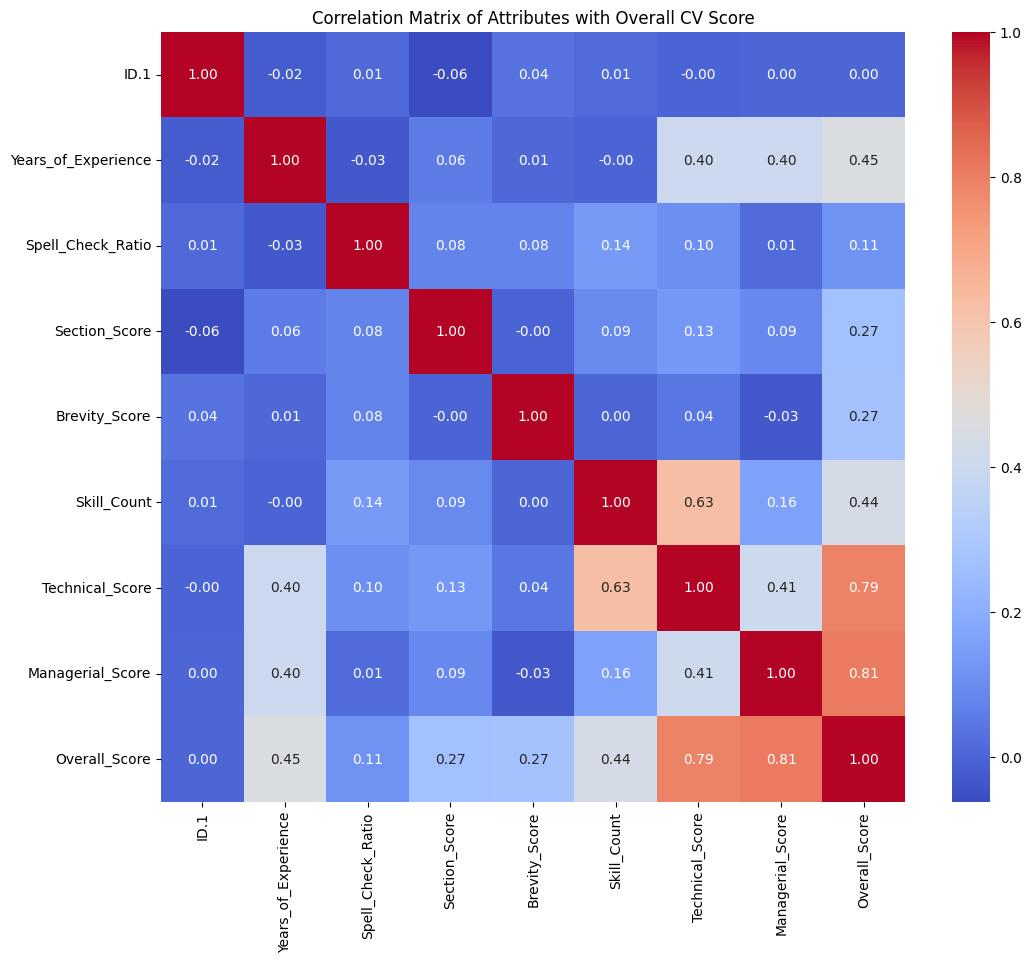

In [ ]:
# prompt: show a plot depicting the correlation of each attribute in resutls_df with the Overall Score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation analysis
numerical_cols = results_df.select_dtypes(include=np.number).columns.tolist()

# Remove 'ID' if it's present
if 'ID' in numerical_cols:
  numerical_cols.remove('ID')

# Calculate the correlation matrix
correlation_matrix = results_df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes with Overall CV Score')
plt.show()


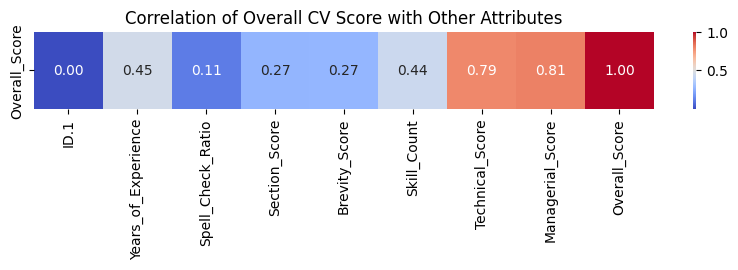

In [ ]:
# prompt: just p-lot last row of the above matrix in heatmap. show labels too

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'correlation_matrix' is defined from the previous code

last_row = correlation_matrix.iloc[-1]

# Create a new DataFrame with only the last row
last_row_df = pd.DataFrame(last_row).transpose()

# Plot the heatmap for the last row
plt.figure(figsize=(10, 1))  # Adjust the figure size if needed
sns.heatmap(last_row_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Overall CV Score with Other Attributes')
plt.show()


In [ ]:
# go inside the Final_Recommendations_Letters folder and create a csv where there are 2 columns with all dir names and subdir names

import os
import csv
import re

import zipfile

with zipfile.ZipFile('Final_Recommendation_Letters.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# get the absolute path of the current working directory
cwd = os.path.abspath("./Final_Recommendation_Letters/")
# create a csv file
with open('dir_subdir.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['dir', 'subdir'])
    # loop through all the directories
    for dir in os.listdir(cwd):
        # extract the number from the directory name
        dir_number = re.findall(r'\d+', dir)[0]
        # loop through all the files in the directory
        for subdir in os.listdir(os.path.join(cwd, dir)):
            # extract the number from the file name
            subdir_number = re.findall(r'\d+', subdir)[0]
            writer.writerow([dir_number, subdir_number])

print('done')

done


In [ ]:
# load the csv file
import pandas as pd
df = pd.read_csv('dir_subdir.csv')
df.head()

,dir,subdir
0,800,794
1,800,959
2,800,712
3,800,517
4,800,851


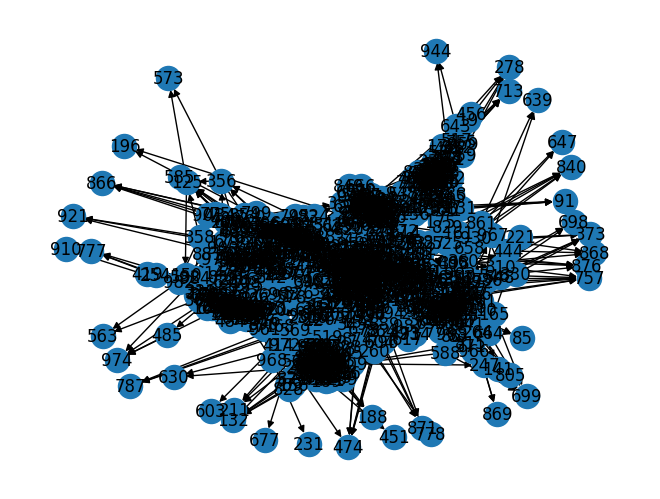

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(df, 'dir', 'subdir', create_using=nx.DiGraph())
nx.draw(G, with_labels=True)

In [ ]:

# Create a dictionary to store edge weights based on Years_of_Experience and Managerial_CV_Score
edge_weights = {}
for u, v in G.edges():
  try:
    recommender_id = int(u)
    recommended_id = int(v)
    recommender_managerial_score = results_df[results_df['ID'] == recommender_id]['Managerial_Score'].values[0]
    recommender_years_of_experience = results_df[results_df['ID'] == recommender_id]['Years_of_Experience'].values[0]
    # Calculate the out-degree of the recommender node
    out_degree = G.out_degree(u)

    # Combine the years of experience, managerial CV score, and out-degree to compute the edge weight
    edge_weight = 0.5 * recommender_years_of_experience + 5 * recommender_managerial_score - 0.1 * out_degree
    edge_weights[(u, v)] = edge_weight
  except IndexError:
      # Handle cases where the ID is not found in the results_df (e.g., if there's a mismatch between the IDs in the graph and in the DataFrame)
      print(f"Warning: ID {u} or {v} not found in results_df. Skipping edge weight calculation.")
      edge_weights[(u, v)] = 0  # Or assign a default weight


# Add edge weights to the graph
nx.set_edge_attributes(G, edge_weights, 'weight')


# Optional: Print the weighted edges
for u, v, data in G.edges(data=True):
    print(f"Edge ({u}, {v}): Weight = {data['weight']}")



Edge (800, 794): Weight = 10.676540155247052
Edge (800, 959): Weight = 10.676540155247052
Edge (800, 712): Weight = 10.676540155247052
Edge (800, 517): Weight = 10.676540155247052
Edge (800, 851): Weight = 10.676540155247052
Edge (794, 902): Weight = 11.506242216687422
Edge (959, 701): Weight = 15.18919957593427
Edge (959, 278): Weight = 15.18919957593427
Edge (959, 527): Weight = 15.18919957593427
Edge (959, 793): Weight = 15.18919957593427
Edge (712, 860): Weight = 8.360443939393939
Edge (712, 12): Weight = 8.360443939393939
Edge (712, 535): Weight = 8.360443939393939
Edge (712, 443): Weight = 8.360443939393939
Edge (517, 959): Weight = 4.836183261183262
Edge (851, 712): Weight = 6.902260765550238
Edge (851, 164): Weight = 6.902260765550238
Edge (851, 393): Weight = 6.902260765550238
Edge (851, 962): Weight = 6.902260765550238
Edge (851, 544): Weight = 6.902260765550238
Edge (881, 975): Weight = 12.662281605113636
Edge (975, 582): Weight = 1.8958874458874455
Edge (975, 38): Weight = 

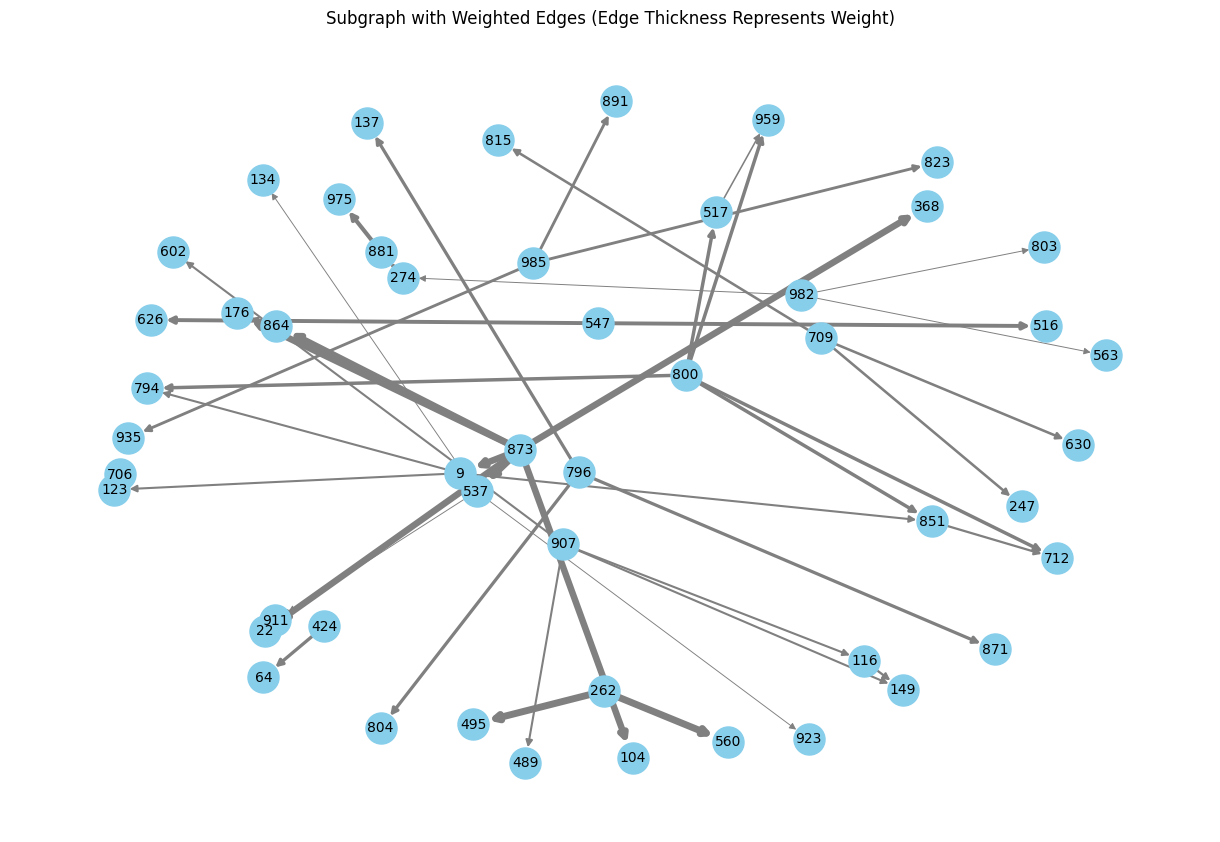

In [ ]:
# prompt: show lesser number of nodes(20) and depict thickness of edge by edge weight.

import matplotlib.pyplot as plt

# Extract a subgraph with a limited number of nodes (e.g., 20)
num_nodes_to_show = 50
subgraph_nodes = list(G.nodes())[:num_nodes_to_show]
subgraph = G.subgraph(subgraph_nodes)

# Get edge weights for the subgraph
edge_widths = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

# Normalize edge widths for better visualization
normalized_edge_widths = [w / max(edge_widths) * 5 if edge_widths else 1 for w in edge_widths]


# Draw the subgraph with edge thickness based on weights
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10,
        edge_color='gray', width=normalized_edge_widths)
plt.title('Subgraph with Weighted Edges (Edge Thickness Represents Weight)')
plt.show()


In [ ]:
df = pd.read_csv('Final_Persons_And_Recommenders.csv')
# change index to the column 'ID'
df.set_index('ID', inplace=True)
df.head()

,Recommenders ID
ID,
0,"[218, 391]"
1,"[412, 869, 233, 289]"
2,"[582, 624, 592, 662, 469]"
3,"[194, 122]"
4,"[763, 726, 589, 977, 950, 543, 30]"


In [ ]:
# calculate PageRank Score for all edges
pr = nx.pagerank(G, alpha=0.9)
# add the PageRank score to the dataframe
df['PageRank'] = df.index.map(pr)
df.head()

,Recommenders ID,PageRank
ID,,
0,"[218, 391]",0.000540
1,"[412, 869, 233, 289]",0.000741
2,"[582, 624, 592, 662, 469]",0.000551
3,"[194, 122]",0.000673
4,"[763, 726, 589, 977, 950, 543, 30]",0.000337


In [ ]:
# find betweennees centrality for all nodes
bc = nx.betweenness_centrality(G)
# add betweenness centrality to the dataframe
df['Betweenness'] = df.index.map(bc)
df['Inverse_Betweenness'] = 1/(df['Betweenness'] + 10)
df.drop('Betweenness', axis=1, inplace=True)
df.head()

,Recommenders ID,PageRank,Inverse_Betweenness
ID,,,
0,"[218, 391]",0.000540,0.099985
1,"[412, 869, 233, 289]",0.000741,0.099983
2,"[582, 624, 592, 662, 469]",0.000551,0.099942
3,"[194, 122]",0.000673,0.099969
4,"[763, 726, 589, 977, 950, 543, 30]",0.000337,0.099980


In [ ]:
# find number of ingoing edges for all nodes
in_deg = G.in_degree()
# add the number of ingoing edges to the dataframe
df['InDegree'] = df.index.map(in_deg)
df.head()

,Recommenders ID,PageRank,Inverse_Betweenness,InDegree
ID,,,,
0,"[218, 391]",0.000540,0.099985,1
1,"[412, 869, 233, 289]",0.000741,0.099983,2
2,"[582, 624, 592, 662, 469]",0.000551,0.099942,2
3,"[194, 122]",0.000673,0.099969,5
4,"[763, 726, 589, 977, 950, 543, 30]",0.000337,0.099980,1


In [ ]:
# prompt: For each node take the sum of the incoming edge weights and store it in df after normalizing

import pandas as pd

# Calculate the sum of incoming edge weights for each node
incoming_edge_weights = {}
for node in G.nodes():
  total_weight = 0
  for u, v, data in G.edges(data=True):
    if v == node:
      total_weight += data['weight']
  incoming_edge_weights[node] = total_weight

# Normalize the incoming edge weights (optional)
max_weight = max(incoming_edge_weights.values())
min_weight = min(incoming_edge_weights.values())
if max_weight != min_weight:
  normalized_incoming_edge_weights = {node: (weight - min_weight) / (max_weight - min_weight) for node, weight in incoming_edge_weights.items()}
else:
  normalized_incoming_edge_weights = {node: 0 for node, weight in incoming_edge_weights.items()}

# Add the normalized incoming edge weights to the DataFrame
df['IncomingEdgeWeightSum'] = df.index.map(normalized_incoming_edge_weights)
df.head()



,Recommenders ID,PageRank,Inverse_Betweenness,InDegree,IncomingEdgeWeightSum
ID,,,,,
0,"[218, 391]",0.000540,0.099985,1,0.055105
1,"[412, 869, 233, 289]",0.000741,0.099983,2,0.132033
2,"[582, 624, 592, 662, 469]",0.000551,0.099942,2,0.130312
3,"[194, 122]",0.000673,0.099969,5,0.386179
4,"[763, 726, 589, 977, 950, 543, 30]",0.000337,0.099980,1,0.056211


In [ ]:
# add flag for all reciprocated edges
df['Reciprocity'] = 0
for i, j in G.edges():
    if G.has_edge(j, i):
        df.loc[j, 'Reciprocity'] = 1
        df.loc[i, 'Reciprocity'] = 1
df.head()

,Recommenders ID,PageRank,Inverse_Betweenness,InDegree,IncomingEdgeWeightSum,Reciprocity
ID,,,,,,
0,"[218, 391]",0.000540,0.099985,1,0.055105,0
1,"[412, 869, 233, 289]",0.000741,0.099983,2,0.132033,0
2,"[582, 624, 592, 662, 469]",0.000551,0.099942,2,0.130312,0
3,"[194, 122]",0.000673,0.099969,5,0.386179,1
4,"[763, 726, 589, 977, 950, 543, 30]",0.000337,0.099980,1,0.056211,0


In [ ]:
# Create a composite score using:

# min max scaling
df['PageRank'] = 100 * (df['PageRank'] - df['PageRank'].min()) / (df['PageRank'].max() - df['PageRank'].min())
df['Inverse_Betweenness'] = 100 * (df['Inverse_Betweenness'] - df['Inverse_Betweenness'].min()) / (df['Inverse_Betweenness'].max() - df['Inverse_Betweenness'].min())

df['CreditScore'] = df['IncomingEdgeWeightSum']*((0.4 * df['PageRank'] + 0.3 * df['Inverse_Betweenness']) / (df['InDegree'] + 1)) - 0.3 * df['Reciprocity']
df['CreditScore'] = 100 * (df['CreditScore'] - df['CreditScore'].min()) / (df['CreditScore'].max() - df['CreditScore'].min())
df.head()

,Recommenders ID,PageRank,Inverse_Betweenness,InDegree,IncomingEdgeWeightSum,Reciprocity,CreditScore
ID,,,,,,,
0,"[218, 391]",8.797186,98.627462,1,0.055105,0,12.492175
1,"[412, 869, 233, 289]",13.110926,98.439740,2,0.132033,0,20.960193
2,"[582, 624, 592, 662, 469]",9.045685,94.671970,2,0.130312,0,19.047309
3,"[194, 122]",11.665597,97.177685,5,0.386179,1,25.701250
4,"[763, 726, 589, 977, 950, 543, 30]",4.452021,98.180386,1,0.056211,0,12.022284


In [ ]:
# save the dataframe to a csv file
df.to_csv('Final_Credit_Score.csv')

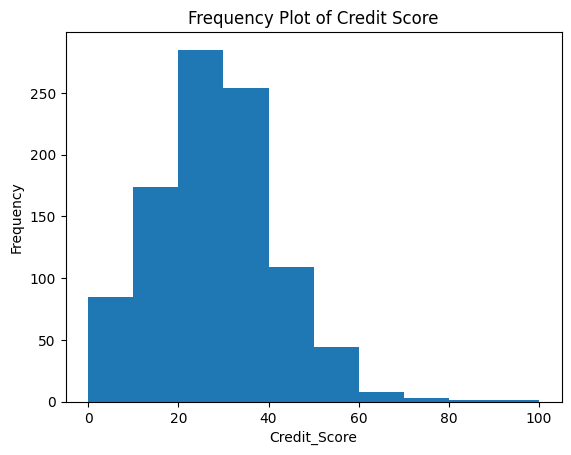

In [ ]:
# df['Inverse_Betweenness'].plot()
df['CreditScore'].plot(kind='hist')
plt.xlabel('Credit_Score')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Credit Score')
plt.show()

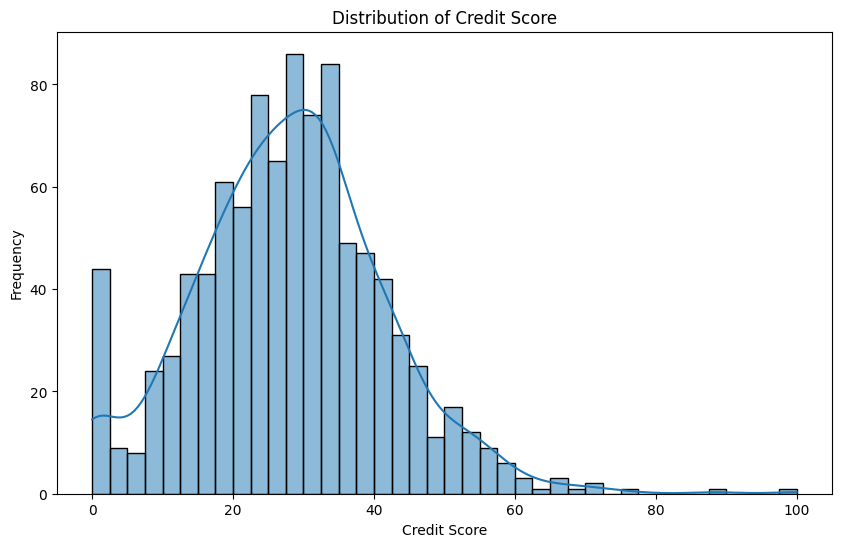

In [ ]:
# prompt: make a kde + hist graph

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['CreditScore'], kde=True, bins=40)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Score')
plt.show()


In [ ]:
# rename dir to cv_id and subdir to rec_id
df.rename(columns={'dir': 'cv_id', 'subdir': 'rec_id'}, inplace=True)
df.head()

,Recommenders ID,PageRank,Inverse_Betweenness,InDegree,IncomingEdgeWeightSum,Reciprocity,CreditScore
ID,,,,,,,
0,"[218, 391]",8.797186,98.627462,1,0.055105,0,12.492175
1,"[412, 869, 233, 289]",13.110926,98.439740,2,0.132033,0,20.960193
2,"[582, 624, 592, 662, 469]",9.045685,94.671970,2,0.130312,0,19.047309
3,"[194, 122]",11.665597,97.177685,5,0.386179,1,25.701250
4,"[763, 726, 589, 977, 950, 543, 30]",4.452021,98.180386,1,0.056211,0,12.022284


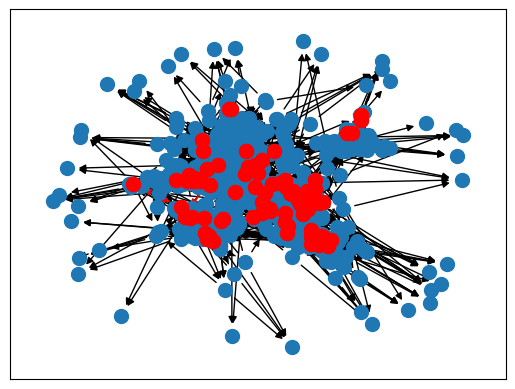

In [ ]:
# find all reciprocal connections
reciprocal_edges = []
for edge in G.edges():
    if (edge[1], edge[0]) in G.edges():
        reciprocal_edges.append(edge)
reciprocal_edges

# visualize the graph with reciprocal connections shown in red
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100)
# nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=reciprocal_edges, edge_color='r', arrows=True)
# also show the reciprocal node in red
nx.draw_networkx_nodes(G, pos, nodelist=[i[0] for i in reciprocal_edges], node_color='r', node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=[i[1] for i in reciprocal_edges], node_color='r', node_size=100)
plt.show()



In [ ]:
# percentage of reciprocal connections
reciprocal_percentage = len(reciprocal_edges) / len(G.edges())
reciprocal_percentage * 100

2.9173419773095626

In [ ]:
!pip install pypdf2 groq

## Level 3

In [ ]:
import os
import zipfile
import chardet
from PyPDF2 import PdfReader
import pandas as pd
import json
import re
from groq import Groq

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to extract PDFs from zipfile, convert them to text, and save as .txt files
def extract_and_save_text_from_zip(zip_file_path, extract_to, output_zip_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    with zipfile.ZipFile(output_zip_path, 'w') as output_zip:
        for root, dirs, files in os.walk(extract_to):
            for file in files:
                if file.endswith(".pdf"):
                    pdf_path = os.path.join(root, file)
                    text = extract_text_from_pdf(pdf_path)

                    text_filename = os.path.splitext(file)[0] + ".txt"
                    text_filepath = os.path.join(extract_to, text_filename)
                    with open(text_filepath, 'w', encoding='utf-8') as text_file:
                        text_file.write(text)

                    output_zip.write(text_filepath, arcname=text_filename)

    print(f"Text files saved and zipped as {output_zip_path}")

# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

# Function for sentiment calculation using Groq API
def sentiment_calculator(text_path):
    with open(text_path, 'r', encoding='Windows-1252') as f:
        text = f.read()

    client = Groq(api_key='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')

    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "system",
                "content": """
                You are provided a piece of text that contains various claims, both normal and exaggerated. Your task is to:
                  1. Identify all the claims in the text.
                  2. For normal claims, assign a sentiment score between 0 and 1.
                  3. For exaggerated claims, assign a sentiment score between 0 and 1.
                  4. Calculate the total sum of sentiment scores for normal claims and exaggerated claims separately.
                  5. Output the result as an integer, calculated using the formula:
                    (Average of normal sentiment scores) - 0.1 * (Average of exaggerated sentiment scores)

                  DO NOT Provide any intermediate steps in the response.

                  The final output should ONLY be the result of this formula.
                  """
            },
            {
                "role": "user",
                "content": f"""The text is provided below:\n {text}

                DO NOT Provide any intermediate steps in the response.

                The final output should ONLY be the result of the formula mentioned above.
                """
            }
        ],
        temperature=0.5,
        max_tokens=4096,
        top_p=1,
        stream=False,
        stop=None,
    )

    return completion.choices[0].message.content

# Function to extract IDs from file paths
def extract_ids(file_path):
    recommendee_id = re.search(r'Recommendation_Letters_of_ID_(\d+)', file_path).group(1)
    recommender_id = re.search(r'Recommendation_From_ID_(\d+)', file_path).group(1)
    return recommendee_id, recommender_id

# Main execution
if __name__ == "__main__":
    # Extract text from resumes
    zip_file_path = "Final_Resumes.zip"
    extract_to = "Final_Resumes_Text"
    output_zip_path = "extracted_text_files.zip"
    extract_and_save_text_from_zip(zip_file_path, extract_to, output_zip_path)

    # Process recommendation letters
    recommendation_dir = 'Final_Recommendation_Letters'
    sentiment_scores = {}

    for root, dirs, files in os.walk(recommendation_dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                file_encoding = detect_encoding(file_path)
                sentiment_score = sentiment_calculator(file_path)
                recommendee_id, recommender_id = extract_ids(file_path)
                sentiment_scores[(recommendee_id, recommender_id)] = float(sentiment_score)

    # Load and process skills data
    df_lor_skills = pd.read_csv('LOR_skills.csv')
    df_lor_skills[['Recommendee_ID', 'Recommender_ID']] = df_lor_skills['File'].apply(lambda x: pd.Series(extract_ids(x)))
    df_lor_skills = df_lor_skills.drop('File', axis=1)
    df_lor_skills = df_lor_skills.sort_values('Recommendee_ID')

    # Load and process resume data
    with open('all_resumes_data.json') as f:
        resume_data = json.load(f)

    df_resume = pd.DataFrame(resume_data)
    df_resume['Recommendee_ID'] = df_resume['File_Name'].apply(lambda x: re.search(r'Resume_of_ID_(\d+)', x).group(1))
    df_resume = df_resume[['Skills', 'Recommendee_ID']]
    df_resume = df_resume.sort_values('Recommendee_ID')

    # Merge sentiment scores with skills data
    df_lor_skills['Sentiment_Score'] = df_lor_skills.apply(lambda row: sentiment_scores.get((row['Recommendee_ID'], row['Recommender_ID']), 0), axis=1)

    # Save processed dataframes
    df_lor_skills.to_csv('processed_lor_skills.csv', index=False)
    df_resume.to_csv('processed_resume_skills.csv', index=False)

    print("Data preparation and initial processing completed.")

Text files saved and zipped as extracted_text_files.zip


In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

def get_embeddings(text):
    """Compute embeddings for given text using RoBERTa"""
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def compute_skill_similarity(resume_skills, rec_skills):
    """Compute cosine similarity between resume skills and recommendation skills"""
    embeddings1 = get_embeddings(resume_skills)
    embeddings2 = get_embeddings(rec_skills)
    return cosine_similarity(embeddings1, embeddings2)[0][0]

def process_skills(skills):
    """Process skills to ensure they are in the correct format"""
    if pd.notna(skills) and isinstance(skills, list) and skills:
        return skills[0]
    return ""

def calculate_average_skill_similarity(df_resume, df_lor):
    """Calculate average skill similarity scores for each resume"""
    average_scores = []

    for _, resume_row in df_resume.iterrows():
        resume_skills = process_skills(resume_row['Skills'])
        if not resume_skills:
            average_scores.append(0.0)
            continue

        recommendations = df_lor[df_lor['Recommendee_ID'] == resume_row['Recommendee_ID']]
        similarity_scores = []

        for _, rec_row in recommendations.iterrows():
            rec_skills = process_skills(rec_row['Skills'])
            if rec_skills:
                similarity = compute_skill_similarity(resume_skills, rec_skills)
                similarity_scores.append(similarity)

        avg_score = sum(similarity_scores) / len(similarity_scores) if similarity_scores else 0.0
        average_scores.append(avg_score)

    return average_scores

def visualize_score_distribution(scores):
    """Visualize the distribution of skill similarity scores"""
    plt.figure(figsize=(10, 6))
    sns.histplot(scores, kde=True)
    plt.title('Distribution of Average Skill Similarity Scores')
    plt.xlabel('Average Skill Similarity Score')
    plt.ylabel('Frequency')
    plt.savefig('skill_similarity_distribution.png')
    plt.close()

def main():
    # Load processed data from Section 1
    df_resume = pd.read_csv('processed_resume_skills.csv')
    df_lor = pd.read_csv('processed_lor_skills.csv')

    print("Computing skill similarity scores...")
    average_scores = calculate_average_skill_similarity(df_resume, df_lor)

    # Add average similarity scores to df_resume
    df_resume['Average_Skill_Similarity'] = average_scores

    # Combine with existing scores (assuming 'Overall_Score' exists from previous analysis)
    if 'Overall_Score' in df_resume.columns:
        df_resume['Final_Score'] = 0.7 * df_resume['Overall_Score'] + 0.3 * df_resume['Average_Skill_Similarity']
    else:
        df_resume['Final_Score'] = df_resume['Average_Skill_Similarity']

    # Normalize Final_Score to 0-100 range
    df_resume['Final_Score'] = (df_resume['Final_Score'] - df_resume['Final_Score'].min()) / (df_resume['Final_Score'].max() - df_resume['Final_Score'].min()) * 100

    print("Visualizing score distribution...")
    visualize_score_distribution(df_resume['Final_Score'])

    # Save the final results
    df_resume.to_csv('final_resume_scores.csv', index=False)
    print("Final scores saved to 'final_resume_scores.csv'")

    # Display top 10 candidates
    top_candidates = df_resume.nlargest(10, 'Final_Score')
    print("\nTop 10 Candidates:")
    print(top_candidates[['Recommendee_ID', 'Final_Score']])

    # Calculate and display summary statistics
    summary_stats = df_resume['Final_Score'].describe()
    print("\nSummary Statistics:")
    print(summary_stats)

if __name__ == "__main__":
    main()


Summary Statistics of Final CV Score:
count    1000.000000
mean       44.969755
std        10.444394
min         4.089058
25%        38.219798
50%        46.064823
75%        51.698515
max        72.996022
Name: Final_CV_Score, dtype: float64


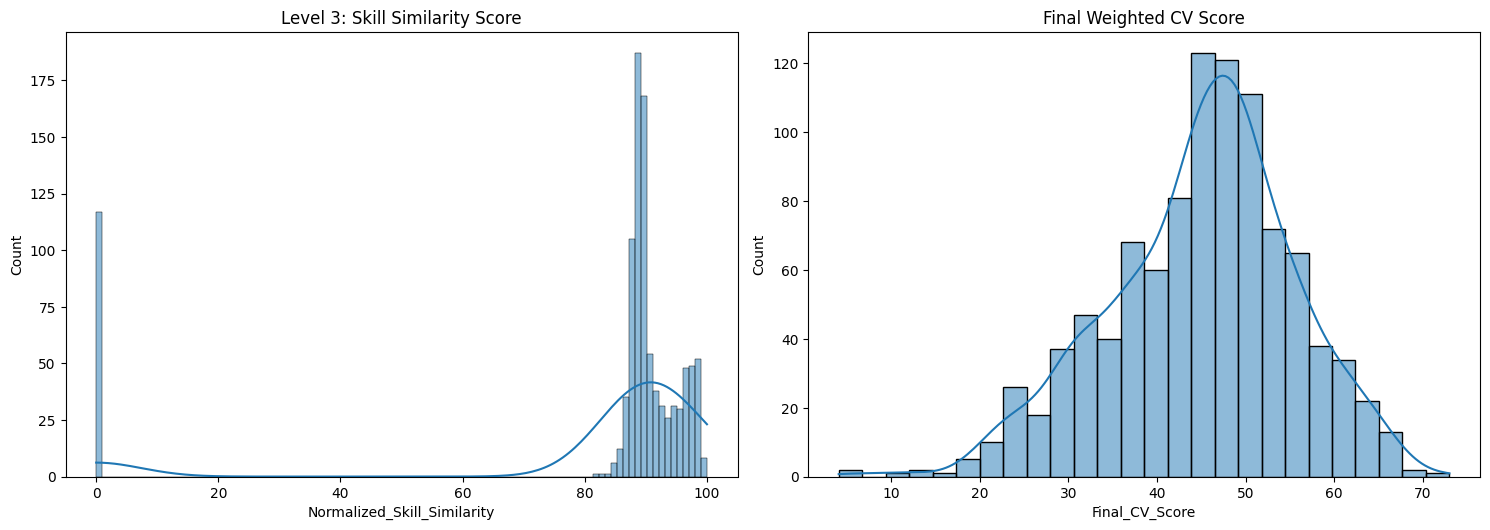

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from each level
df_level1 = pd.read_csv('final_ranked_resumes.csv')
df_level2 = pd.read_csv('final_credit_scores.csv')
df_level3 = pd.read_csv('df_resume_sorted.csv')


# Normalize scores to 0-100 range
def normalize_score(series):
    return 100 * (series - series.min()) / (series.max() - series.min())

df_combined = pd.DataFrame()

df_combined['Normalized_Overall_Score'] = normalize_score(df_level1['Overall_Score'])
df_combined['Normalized_CreditScore'] = (df_level2['CreditScore'])
df_combined['Normalized_Skill_Similarity'] = normalize_score(df_level3['Average_Skill_Similarity'])

# Calculate final weighted score
df_combined['Final_CV_Score'] = (
    0.60 * df_combined['Normalized_Overall_Score'] +
    0.25 * df_combined['Normalized_CreditScore'] +
    0.15 * df_combined['Normalized_Skill_Similarity']
)

# Visualize distributions
plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# sns.histplot(df_combined['Normalized_Overall_Score'], kde=True)
# plt.title('Level 1: Initial Resume Screening Score')

# plt.subplot(2, 2, 2)
# sns.histplot(df_combined['Normalized_CreditScore'], kde=True)
# plt.title('Level 2: Network Analysis Score')

plt.subplot(2, 2, 1)
sns.histplot(df_combined['Normalized_Skill_Similarity'], kde=True)
plt.title('Level 3: Skill Similarity Score')

plt.subplot(2, 2, 2)
sns.histplot(df_combined['Final_CV_Score'], kde=True)
plt.title('Final Weighted CV Score')

plt.tight_layout()
plt.savefig('score_distributions.png')


# Save final results
df_combined.to_csv('final_cv_scores.csv', index=False)

# Print summary statistics
print("\nSummary Statistics of Final CV Score:")
print(df_combined['Final_CV_Score'].describe())